In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [4]:
def model_inputs(real_dim, z_dim):
    #discriminator input
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    #generator input
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [5]:
#build the generator
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        #hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        #leaky ReLU
        h1 = tf.maximum(alpha*h1, h1)
        
        #logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [6]:
#build the discriminator
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        #hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        #leaky ReLU
        h1 = tf.maximum(h1*alpha, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [7]:
# Hyperparameters
# size of input image to discriminator
input_size = 784
#size_of latent vector to generator
z_size = 100
#sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
#leak factor for leaky ReLU
alpha = 0.01
# Smoothing
smooth = 0.1

In [8]:
# build the network
tf.reset_default_graph()
#create input placeholders
input_real, input_z = model_inputs(input_size, z_size)

#build the model
#g_model is the output of the generator
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

In [9]:
# calculate losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
d_loss = d_loss_real + d_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

In [10]:
# Optimizers
learning_rate = 0.002

#get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [14]:
# Training
import os
save_path = 'checkpoints/'
model_name = 'generator.ckpt'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
save_path_full = os.path.join(save_path, model_name)

batch_size = 100
epochs = 100
samples =[]
losses = []
# Only save the generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            #run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
            
        # at the end of each epoch, get losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print('Epoch {}/{}...'.format(e+1, epochs), 'Discriminator Loss: {:.4f}...'.format(train_loss_d), 'Generator Loss: {:.4f}'.format(train_loss_g))
        
        #save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        #sample from generator as we are training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, reuse=True), feed_dict={input_z:sample_z})
        samples.append(gen_samples)
        saver.save(sess, save_path_full)
        
# save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3655... Generator Loss: 4.1202
Epoch 2/100... Discriminator Loss: 0.3897... Generator Loss: 3.4079
Epoch 3/100... Discriminator Loss: 0.4189... Generator Loss: 3.1519
Epoch 4/100... Discriminator Loss: 0.8958... Generator Loss: 2.9906
Epoch 5/100... Discriminator Loss: 2.0072... Generator Loss: 8.9856
Epoch 6/100... Discriminator Loss: 2.0460... Generator Loss: 3.1464
Epoch 7/100... Discriminator Loss: 1.5998... Generator Loss: 1.7626
Epoch 8/100... Discriminator Loss: 1.8029... Generator Loss: 0.9377
Epoch 9/100... Discriminator Loss: 1.7439... Generator Loss: 1.7720
Epoch 10/100... Discriminator Loss: 0.9308... Generator Loss: 1.2967
Epoch 11/100... Discriminator Loss: 1.6662... Generator Loss: 2.2114
Epoch 12/100... Discriminator Loss: 1.2715... Generator Loss: 1.6580
Epoch 13/100... Discriminator Loss: 1.1477... Generator Loss: 1.2023
Epoch 14/100... Discriminator Loss: 0.7865... Generator Loss: 3.3706
Epoch 15/100... Discriminator Loss: 1.0688.

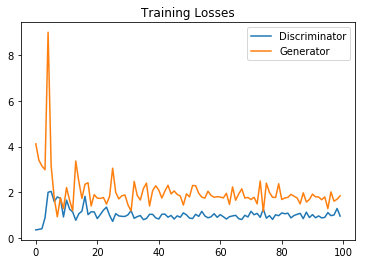

In [17]:
# check out the trining losses for the generator and the discriminator
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()

In [21]:
# view samples of images from the generator
# images taken while trining
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    return fig, axes

In [19]:
# load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

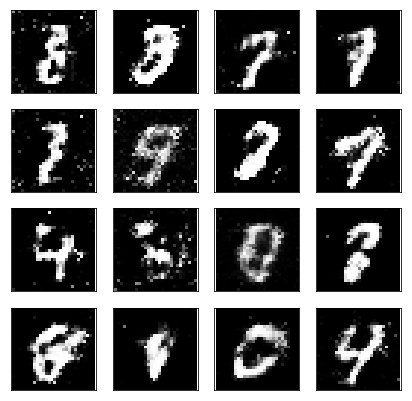

In [22]:
_ = view_samples(-1, samples)

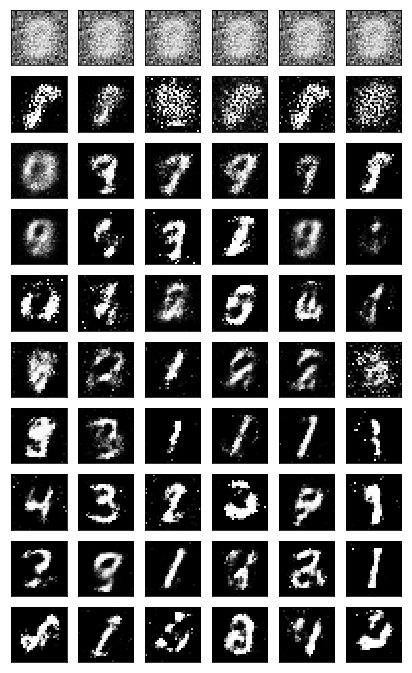

In [24]:
# generated images as the network was training every 10 epochs
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7, 12), nrows=rows, ncols=cols, sharex=True, sharey=True)
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


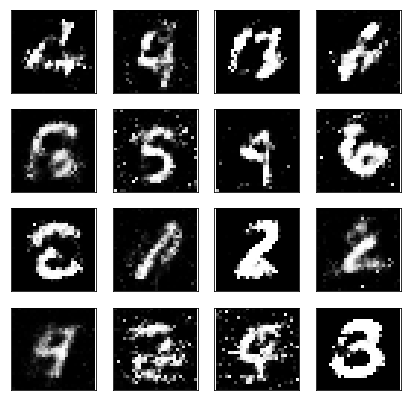

In [25]:
# generate completely new images from generator
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, reuse=True),
                          feed_dict={input_z: sample_z})
    _ = view_samples(0, [gen_samples])